# Modeling: Hospital Readmission Prediction

This notebook implements multiple binary classification models to predict hospital readmissions.

## Models to Evaluate
1. **Logistic Regression** - Baseline, highly interpretable
2. **Random Forest** - Handles mixed data types, provides feature importance
3. **XGBoost** - Often best performance, provides feature importance

## Evaluation Metrics
- Accuracy
- Precision, Recall, F1-Score
- ROC-AUC (important for imbalanced classification)
- Confusion Matrix


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)
import xgboost as xgb

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10


### Load Data


In [2]:
# Load cleaned data
df = pd.read_csv('Data/anxiety_disorder_admission_data_cleaned.csv')

print(f"Dataset shape: {df.shape}")
print()
print(f"Target variable distribution:")
print(df['readmitted_binary'].value_counts())
print()
print(f"Readmission rate: {df['readmitted_binary'].mean()*100:.2f}%")

# Check for missing values
print()
print(f"Missing values: {df.isnull().sum().sum()}")
if df.isnull().sum().sum() > 0:
    print()
    print("Columns with missing values:")
    missing_cols = df.columns[df.isnull().any()].tolist()
    for col in missing_cols:
        print(f"  {col}: {df[col].isnull().sum()} ({df[col].isnull().sum()/len(df)*100:.2f}%)")


Dataset shape: (86385, 52)

Target variable distribution:
readmitted_binary
0    46614
1    39771
Name: count, dtype: int64

Readmission rate: 46.04%

Missing values: 0


### Preprocessing


In [3]:
# Prepare features and target
# Drop ID columns, target variable(s), and data leakage features
# discharge_disposition_id is data leakage: it tells us where patient was discharged to,
# but I assume we need to predict readmission BEFORE discharge (?)
features_to_drop = ['encounter_id', 'patient_nbr', 'readmitted', 'readmitted_binary', 'discharge_disposition_id']
X = df.drop(columns=[col for col in features_to_drop if col in df.columns])
y = df['readmitted_binary']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print()
print(f"Feature types:")
print(X.dtypes.value_counts())

# Separate categorical and numerical features
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print()
print(f"Categorical features ({len(categorical_cols)}): {categorical_cols[:5]}...")
print(f"Numerical features ({len(numerical_cols)}): {numerical_cols[:5]}...")


Features shape: (86385, 47)
Target shape: (86385,)

Feature types:
object    33
int64     14
Name: count, dtype: int64

Categorical features (33): ['race', 'gender', 'age', 'payer_code', 'medical_specialty']...
Numerical features (14): ['admission_type_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures']...


In [4]:
# Encode categorical variables using Label Encoding

X_encoded = X.copy()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
    label_encoders[col] = le
    print(f"Encoded {col}: {len(le.classes_)} unique values")

print()
print(f"Final feature matrix shape: {X_encoded.shape}")
print(f"All features are now numerical: {X_encoded.select_dtypes(include=[np.number]).shape[1] == X_encoded.shape[1]}")


Encoded race: 6 unique values
Encoded gender: 3 unique values
Encoded age: 10 unique values
Encoded payer_code: 18 unique values
Encoded medical_specialty: 73 unique values
Encoded diag_1: 697 unique values
Encoded diag_2: 728 unique values
Encoded diag_3: 770 unique values
Encoded sertraline: 4 unique values
Encoded escitalopram: 4 unique values
Encoded fluoxetine: 4 unique values
Encoded paroxetine: 3 unique values
Encoded venlafaxine: 4 unique values
Encoded duloxetine: 2 unique values
Encoded buspirone: 4 unique values
Encoded clonazepam: 4 unique values
Encoded alprazolam: 2 unique values
Encoded lorazepam: 4 unique values
Encoded diazepam: 4 unique values
Encoded hydroxyzine: 4 unique values
Encoded propranolol: 4 unique values
Encoded pregabalin: 2 unique values
Encoded gabapentin: 3 unique values
Encoded trazodone: 1 unique values
Encoded mirtazapine: 1 unique values
Encoded psychotherapy: 4 unique values
Encoded sertraline-buspirone: 4 unique values
Encoded escitalopram-clonaz

### Train-Test Split


In [5]:
# Split data into train and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, 
    test_size=0.2, 
    stratify=y  # Ensure balanced split
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print()
print(f"Training set readmission rate: {y_train.mean()*100:.2f}%")
print(f"Test set readmission rate: {y_test.mean()*100:.2f}%")


Training set: 69,108 samples
Test set: 17,277 samples

Training set readmission rate: 46.04%
Test set readmission rate: 46.04%


### Model Training and Evaluation


In [6]:
# Store results for comparison
results = {}

def evaluate_model(model, model_name, X_train, y_train, X_test, y_test):
    """Train and evaluate a model, returning metrics and predictions"""
    
    # Train model
    print()
    print(f"{'='*60}")
    print(f"Training {model_name}...")
    print(f"{'='*60}")
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Store results
    results[model_name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    
    # Print results
    print()
    print(f"{model_name} Performance:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {roc_auc:.4f}")
    
    print()
    print(f"Confusion Matrix:")
    print(results[model_name]['confusion_matrix'])
    
    print()
    print(f"Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Readmission', 'Readmission']))
    
    return results[model_name]


### Model 1: Logistic Regression

- Provides interpretable coefficients (can see which features increase/decrease readmission risk)
- Good baseline model
- Fast to train
- Works well with standardized features


In [7]:
# Standardize features for logistic regression (important for regularization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression with regularization
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced'  # Handle class imbalance
)

evaluate_model(lr_model, 'Logistic Regression', X_train_scaled, y_train, X_test_scaled, y_test)



Training Logistic Regression...

Logistic Regression Performance:
  Accuracy:  0.6159
  Precision: 0.5947
  Recall:    0.5202
  F1-Score:  0.5550
  ROC-AUC:   0.6557

Confusion Matrix:
[[6503 2820]
 [3816 4138]]

Classification Report:
                precision    recall  f1-score   support

No Readmission       0.63      0.70      0.66      9323
   Readmission       0.59      0.52      0.55      7954

      accuracy                           0.62     17277
     macro avg       0.61      0.61      0.61     17277
  weighted avg       0.61      0.62      0.61     17277



{'model': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
 'accuracy': 0.6159055391561035,
 'precision': 0.5947111238861742,
 'recall': 0.5202413879808901,
 'f1': 0.5549892703862661,
 'roc_auc': 0.6557276634976978,
 'y_pred': array([1, 1, 1, ..., 1, 0, 0], shape=(17277,)),
 'y_pred_proba': array([0.6060743 , 0.50706858, 0.58149242, ..., 0.59559437, 0.35629189,
        0.4068844 ], shape=(17277,)),
 'confusion_matrix': array([[6503, 2820],
        [3816, 4138]])}

### Model 2: Random Forest

- Handles mixed data types (no need for scaling)
- Provides feature importance scores (helps answer "why" questions)
- Robust to outliers and missing values
- Good performance on tabular data
- Can capture non-linear relationships


In [8]:
# Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

evaluate_model(rf_model, 'Random Forest', X_train, y_train, X_test, y_test)



Training Random Forest...

Random Forest Performance:
  Accuracy:  0.6318
  Precision: 0.6053
  Recall:    0.5758
  F1-Score:  0.5902
  ROC-AUC:   0.6804

Confusion Matrix:
[[6336 2987]
 [3374 4580]]

Classification Report:
                precision    recall  f1-score   support

No Readmission       0.65      0.68      0.67      9323
   Readmission       0.61      0.58      0.59      7954

      accuracy                           0.63     17277
     macro avg       0.63      0.63      0.63     17277
  weighted avg       0.63      0.63      0.63     17277



{'model': RandomForestClassifier(class_weight='balanced', max_depth=15,
                        min_samples_leaf=5, min_samples_split=10, n_jobs=-1,
                        random_state=42),
 'accuracy': 0.6318226543960178,
 'precision': 0.6052596801903,
 'recall': 0.5758109127483028,
 'f1': 0.5901681592680884,
 'roc_auc': 0.6803571625552278,
 'y_pred': array([1, 0, 1, ..., 1, 0, 0], shape=(17277,)),
 'y_pred_proba': array([0.57262651, 0.34462785, 0.68304499, ..., 0.55455254, 0.29176773,
        0.42439366], shape=(17277,)),
 'confusion_matrix': array([[6336, 2987],
        [3374, 4580]])}

### Model 3: XGBoost

- Often achieves best performance on structured/tabular data
- Provides feature importance scores
- Handles class imbalance well
- Fast and memory efficient
- Good for competition-style problems


In [9]:
# XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),  # Handle class imbalance
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

evaluate_model(xgb_model, 'XGBoost', X_train, y_train, X_test, y_test)



Training XGBoost...

XGBoost Performance:
  Accuracy:  0.6377
  Precision: 0.6055
  Recall:    0.6116
  F1-Score:  0.6085
  ROC-AUC:   0.6908

Confusion Matrix:
[[6153 3170]
 [3089 4865]]

Classification Report:
                precision    recall  f1-score   support

No Readmission       0.67      0.66      0.66      9323
   Readmission       0.61      0.61      0.61      7954

      accuracy                           0.64     17277
     macro avg       0.64      0.64      0.64     17277
  weighted avg       0.64      0.64      0.64     17277



{'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, feature_weights=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=6, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=100, n_jobs=-1,
               num_parallel_tree=None, ...),
 'accuracy': 0.6377264571395497,
 'precision': 0.6054760423148724,
 'recall': 0.6116419411616797,
 'f1': 0.6085433735693289,
 'roc_auc': 0.6908154191114624,
 'y_pred': array([1, 0, 1, ..., 0, 0, 0], shape=(

## Optimizing XGBoost to Reduce False Negatives

**Medical Context**: False negatives (predicting "no readmission" when patient is actually readmitted) are critical - it'd be bad to send high-risk patients home without support.

**Strategies**:
1. **Adjust classification threshold** - Lower threshold = more positive predictions = higher recall
2. **Increase scale_pos_weight** - Penalize false negatives more heavily
3. **Find optimal threshold** that balances recall and precision


In [10]:
# Get predictions from the current XGBoost model
xgb_results = results['XGBoost']
y_pred_proba_xgb = xgb_results['y_pred_proba']

# Function to evaluate at different thresholds
def evaluate_at_threshold(y_true, y_proba, threshold):
    """Evaluate model at a specific threshold"""
    y_pred = (y_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    return {
        'threshold': threshold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
        'false_negatives': fn,
        'false_positive_rate': fp / (fp + tn) if (fp + tn) > 0 else 0
    }

# Test different thresholds with finer granularity for better optimization
thresholds = np.arange(0.25, 0.7, 0.025)  # 0.025 steps for more precision
threshold_results = []

for thresh in thresholds:
    result = evaluate_at_threshold(y_test, y_pred_proba_xgb, thresh)
    threshold_results.append(result)

threshold_df = pd.DataFrame(threshold_results)

# Get baseline metrics at threshold 0.5 for comparison
baseline_result = evaluate_at_threshold(y_test, y_pred_proba_xgb, 0.5)
baseline_fn = baseline_result['fn']

print("Performance at Different Classification Thresholds:")
print("="*80)
# Display key columns for readability
display_cols = ['threshold', 'recall', 'precision', 'f1', 'fn', 'fp']
print(threshold_df[display_cols].round(4).to_string(index=False))

# Find threshold that maximizes recall while keeping precision reasonable
# Target: Recall > 0.75 (catch 75% of readmissions) while precision > 0.50
target_thresholds = threshold_df[
    (threshold_df['recall'] >= 0.75) & (threshold_df['precision'] >= 0.50)
]


# Pick threshold with best F1 score among those meeting criteria
best_threshold_row = target_thresholds.loc[target_thresholds['f1'].idxmax()]
optimal_threshold = best_threshold_row['threshold']
fn_reduction = baseline_fn - best_threshold_row['fn']
fn_reduction_pct = (fn_reduction / baseline_fn * 100) if baseline_fn > 0 else 0

print()
print(f"{'='*80}")
print(f"Recommended Threshold: {optimal_threshold:.3f}")
print(f"  - Recall: {best_threshold_row['recall']:.4f} (catches {best_threshold_row['recall']*100:.1f}% of readmissions)")
print(f"  - Precision: {best_threshold_row['precision']:.4f}")
print(f"  - F1-Score: {best_threshold_row['f1']:.4f}")
print(f"  - False Negatives: {int(best_threshold_row['fn']):,} (reduced from {int(baseline_fn):,} - {fn_reduction_pct:.1f}% reduction)")
print(f"  - False Positives: {int(best_threshold_row['fp']):,} (increased from {int(baseline_result['fp']):,})")
best_threshold_row_final = best_threshold_row

Performance at Different Classification Thresholds:
 threshold  recall  precision     f1   fn   fp
     0.250  0.9794     0.4778 0.6422  164 8515
     0.275  0.9683     0.4856 0.6468  252 8159
     0.300  0.9521     0.4942 0.6507  381 7750
     0.325  0.9303     0.5039 0.6537  554 7285
     0.350  0.9036     0.5148 0.6559  767 6773
     0.375  0.8724     0.5278 0.6577 1015 6209
     0.400  0.8337     0.5419 0.6569 1323 5605
     0.425  0.7844     0.5569 0.6513 1715 4965
     0.450  0.7286     0.5734 0.6417 2159 4312
     0.475  0.6714     0.5895 0.6278 2614 3718
     0.500  0.6116     0.6055 0.6085 3089 3170
     0.525  0.5495     0.6208 0.5830 3583 2670
     0.550  0.4913     0.6378 0.5551 4046 2219
     0.575  0.4381     0.6593 0.5264 4469 1801
     0.600  0.3803     0.6736 0.4861 4929 1466
     0.625  0.3283     0.6922 0.4453 5343 1161
     0.650  0.2775     0.7110 0.3992 5747  897
     0.675  0.2279     0.7379 0.3483 6141  644

Recommended Threshold: 0.375
  - Recall: 0.8724 (catch

## Threshold Optimization for Medical Context

**Goal**: Reduce false negatives (missed readmissions) by adjusting classification threshold.


In [11]:
# Compare baseline (0.5) vs optimal threshold
baseline_metrics = evaluate_at_threshold(y_test, y_pred_proba_xgb, 0.5)
optimal_metrics = evaluate_at_threshold(y_test, y_pred_proba_xgb, optimal_threshold)

print()
print(f"{'='*80}")
print("BASELINE (Threshold 0.5) vs OPTIMAL THRESHOLD COMPARISON")
print(f"{'='*80}")

comparison_simple = pd.DataFrame({
    'Metric': ['Threshold', 'Recall', 'Accuracy', 'Precision', 'F1-Score', 'False Negatives'],
    'Baseline (0.5)': [
        f"{baseline_metrics['threshold']:.2f}",
        f"{baseline_metrics['recall']:.4f}",
        f"{baseline_metrics['accuracy']:.4f}",
        f"{baseline_metrics['precision']:.4f}",
        f"{baseline_metrics['f1']:.4f}",
        f"{int(baseline_metrics['fn']):,}"
    ],
    f'Optimal ({optimal_threshold:.3f})': [
        f"{optimal_metrics['threshold']:.3f}",
        f"{optimal_metrics['recall']:.4f}",
        f"{optimal_metrics['accuracy']:.4f}",
        f"{optimal_metrics['precision']:.4f}",
        f"{optimal_metrics['f1']:.4f}",
        f"{int(optimal_metrics['fn']):,}"
    ],
    'Improvement': [
        '',
        f"+{(optimal_metrics['recall'] - baseline_metrics['recall'])*100:.1f}%",
        f"{(optimal_metrics['accuracy'] - baseline_metrics['accuracy'])*100:+.1f}%",
        f"{(optimal_metrics['precision'] - baseline_metrics['precision'])*100:+.1f}%",
        f"{(optimal_metrics['f1'] - baseline_metrics['f1'])*100:+.1f}%",
        f"-{(baseline_metrics['fn'] - optimal_metrics['fn']):,} ({((baseline_metrics['fn'] - optimal_metrics['fn']) / baseline_metrics['fn'] * 100):.1f}% reduction)"
    ]
})

print(comparison_simple.to_string(index=False))

print(f"By lowering threshold to {optimal_threshold:.3f}:")
print(f"  - Caught {(optimal_metrics['recall'] - baseline_metrics['recall'])*100:.1f}% more readmissions")
print(f"  - Reduced false negatives by {baseline_metrics['fn'] - optimal_metrics['fn']:,} patients")
print(f"  - Traded-off: More false positives (typically more acceptabled in medical context)")



BASELINE (Threshold 0.5) vs OPTIMAL THRESHOLD COMPARISON
         Metric Baseline (0.5) Optimal (0.375)              Improvement
      Threshold           0.50           0.375                         
         Recall         0.6116          0.8724                   +26.1%
       Accuracy         0.6377          0.5819                    -5.6%
      Precision         0.6055          0.5278                    -7.8%
       F1-Score         0.6085          0.6577                    +4.9%
False Negatives          3,089           1,015 -2,074 (67.1% reduction)
By lowering threshold to 0.375:
  - Caught 26.1% more readmissions
  - Reduced false negatives by 2,074 patients
  - Traded-off: More false positives (typically more acceptabled in medical context)


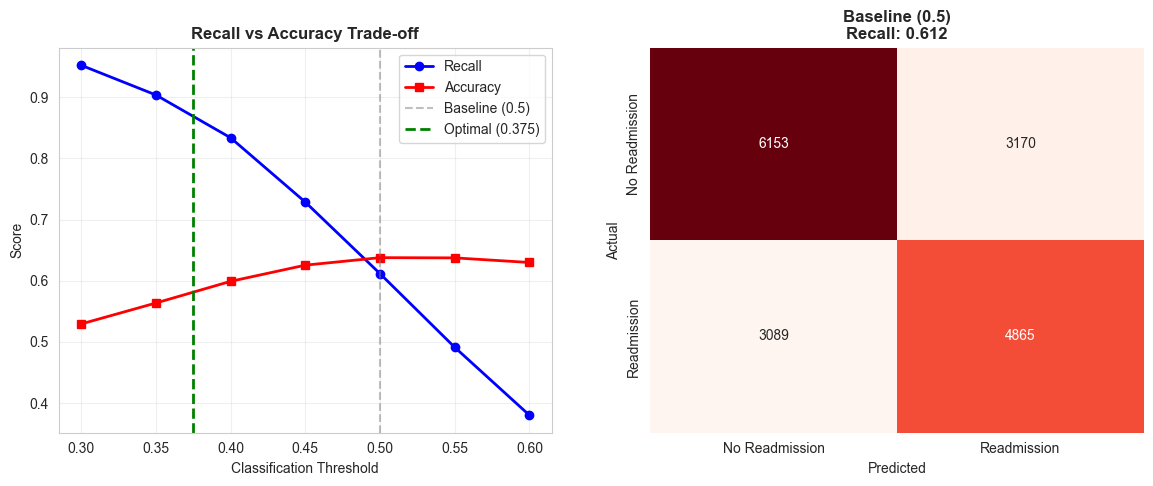

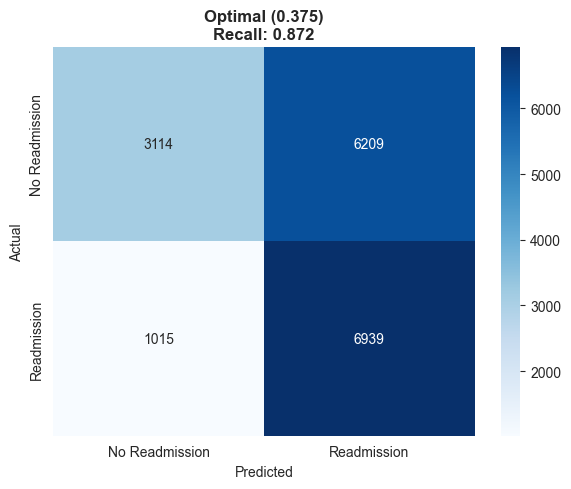

In [12]:
# Simple visualization: Recall vs Accuracy trade-off
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Recall and Accuracy by threshold
test_thresholds = np.arange(0.3, 0.65, 0.05)
recall_vals = [evaluate_at_threshold(y_test, y_pred_proba_xgb, t)['recall'] for t in test_thresholds]
accuracy_vals = [evaluate_at_threshold(y_test, y_pred_proba_xgb, t)['accuracy'] for t in test_thresholds]

axes[0].plot(test_thresholds, recall_vals, 'b-o', label='Recall', linewidth=2, markersize=6)
axes[0].plot(test_thresholds, accuracy_vals, 'r-s', label='Accuracy', linewidth=2, markersize=6)
axes[0].axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, label='Baseline (0.5)')
axes[0].axvline(x=optimal_threshold, color='g', linestyle='--', linewidth=2, label=f'Optimal ({optimal_threshold:.3f})')
axes[0].set_xlabel('Classification Threshold')
axes[0].set_ylabel('Score')
axes[0].set_title('Recall vs Accuracy Trade-off', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Confusion matrices comparison
cm_baseline = confusion_matrix(y_test, (y_pred_proba_xgb >= 0.5).astype(int))
cm_optimal = confusion_matrix(y_test, (y_pred_proba_xgb >= optimal_threshold).astype(int))

sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Reds', ax=axes[1], 
            xticklabels=['No Readmission', 'Readmission'],
            yticklabels=['No Readmission', 'Readmission'], cbar=False)
axes[1].set_title(f'Baseline (0.5)\nRecall: {baseline_metrics["recall"]:.3f}', fontweight='bold')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

# Add optimal confusion matrix next to baseline
fig2, ax2 = plt.subplots(1, 1, figsize=(6, 5))
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['No Readmission', 'Readmission'],
            yticklabels=['No Readmission', 'Readmission'])
ax2.set_title(f'Optimal ({optimal_threshold:.3f})\nRecall: {optimal_metrics["recall"]:.3f}', fontweight='bold')
ax2.set_ylabel('Actual')
ax2.set_xlabel('Predicted')

plt.tight_layout()
plt.show()


### Retraining XGBoost with Improved Parameters for Medical Context

1. **Higher scale_pos_weight** - More heavily penalize false negatives
2. **Optimized hyperparameters** - Focus on recall
3. **Use optimal threshold** for final predictions


Original scale_pos_weight: 1.17
Improved scale_pos_weight: 1.76

This will make the model more conservative (predict readmission more often)
to reduce false negatives (missed readmissions).
Training improved XGBoost model...

IMPROVED XGBOOST PERFORMANCE (at optimal threshold)
  Accuracy:  0.5268
  Precision: 0.4928
  Recall:    0.9556 (catches 95.6% of readmissions)
  F1-Score:  0.6503

  False Negatives: 353 (patients we'd miss)
  False Positives:  7,823 (patients flagged but don't need readmission)

COMPARISON: Original vs Improved XGBoost

         Metric Original XGBoost (threshold 0.5) Improved XGBoost (threshold 0.38)              Improvement
         Recall                           0.6116                            0.9556                   +34.4%
      Precision                           0.6055                            0.4928                   -11.3%
       F1-Score                           0.6085                            0.6503                     4.2%
False Negatives   

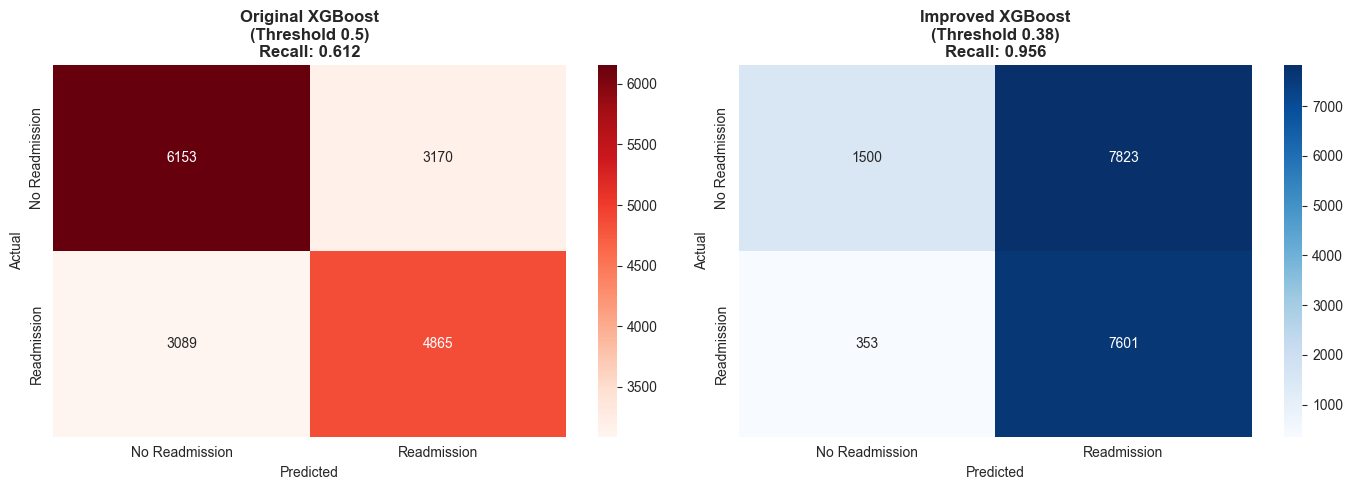

In [13]:
# Calculate improved scale_pos_weight
# Increase it to penalize false negatives more (default was balanced)
# Higher value = more weight on positive class = more aggressive at predicting readmission
base_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])
improved_weight = base_weight * 1.5  # 50% more weight on positive class

print(f"Original scale_pos_weight: {base_weight:.2f}")
print(f"Improved scale_pos_weight: {improved_weight:.2f}")
print()
print(f"This will make the model more conservative (predict readmission more often)")
print(f"to reduce false negatives (missed readmissions).")

# Train improved XGBoost
xgb_improved = xgb.XGBClassifier(
    n_estimators=150,  # More trees
    max_depth=6,
    learning_rate=0.08,  # Slightly lower learning rate
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=improved_weight,  # Higher weight on positive class
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

print("Training improved XGBoost model...")
xgb_improved.fit(X_train, y_train)

# Get predictions
y_pred_proba_improved = xgb_improved.predict_proba(X_test)[:, 1]

# Evaluate at optimal threshold
optimal_result_improved = evaluate_at_threshold(y_test, y_pred_proba_improved, optimal_threshold)

print()
print(f"{'='*80}")
print("IMPROVED XGBOOST PERFORMANCE (at optimal threshold)")
print(f"{'='*80}")
print(f"  Accuracy:  {optimal_result_improved['accuracy']:.4f}")
print(f"  Precision: {optimal_result_improved['precision']:.4f}")
print(f"  Recall:    {optimal_result_improved['recall']:.4f} (catches {optimal_result_improved['recall']*100:.1f}% of readmissions)")
print(f"  F1-Score:  {optimal_result_improved['f1']:.4f}")
print()
print(f"  False Negatives: {int(optimal_result_improved['fn']):,} (patients we'd miss)")
print(f"  False Positives:  {int(optimal_result_improved['fp']):,} (patients flagged but don't need readmission)")

# Compare with original
print()
print(f"{'='*80}")
print("COMPARISON: Original vs Improved XGBoost")
print(f"{'='*80}")
print()


comparison_improved = pd.DataFrame({
    'Metric': ['Recall', 'Precision', 'F1-Score', 'False Negatives', 'False Positives'],
    'Original XGBoost (threshold 0.5)': [
        f"{baseline_result['recall']:.4f}",
        f"{baseline_result['precision']:.4f}",
        f"{baseline_result['f1']:.4f}",
        f"{int(baseline_result['fn']):,}",
        f"{int(baseline_result['fp']):,}"
    ],
    f'Improved XGBoost (threshold {optimal_threshold:.2f})': [
        f"{optimal_result_improved['recall']:.4f}",
        f"{optimal_result_improved['precision']:.4f}",
        f"{optimal_result_improved['f1']:.4f}",
        f"{int(optimal_result_improved['fn']):,}",
        f"{int(optimal_result_improved['fp']):,}"
    ],
    'Improvement': [
        f"+{(optimal_result_improved['recall'] - baseline_result['recall'])*100:.1f}%",
        f"{(optimal_result_improved['precision'] - baseline_result['precision'])*100:.1f}%",
        f"{(optimal_result_improved['f1'] - baseline_result['f1'])*100:.1f}%",
        f"-{(baseline_result['fn'] - optimal_result_improved['fn']):,} ({((baseline_result['fn'] - optimal_result_improved['fn']) / baseline_result['fn'] * 100):.1f}% reduction)",
        f"+{(optimal_result_improved['fp'] - baseline_result['fp']):,}"
    ]
})

print(comparison_improved.to_string(index=False))

# Add improved XGBoost to results dictionary for comparison graphs and feature importance
y_pred_improved = (y_pred_proba_improved >= optimal_threshold).astype(int)
results['XGBoost (Improved)'] = {
    'model': xgb_improved,
    'accuracy': optimal_result_improved['accuracy'],
    'precision': optimal_result_improved['precision'],
    'recall': optimal_result_improved['recall'],
    'f1': optimal_result_improved['f1'],
    'roc_auc': roc_auc_score(y_test, y_pred_proba_improved),
    'y_pred': y_pred_improved,
    'y_pred_proba': y_pred_proba_improved,
    'confusion_matrix': confusion_matrix(y_test, y_pred_improved),
    'threshold': optimal_threshold
}

# Visualize confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original
cm_original = confusion_matrix(y_test, (y_pred_proba_xgb >= 0.5).astype(int))
sns.heatmap(cm_original, annot=True, fmt='d', cmap='Reds', ax=axes[0],
            xticklabels=['No Readmission', 'Readmission'],
            yticklabels=['No Readmission', 'Readmission'])
axes[0].set_title(f'Original XGBoost\n(Threshold 0.5)\nRecall: {baseline_result["recall"]:.3f}', fontweight='bold')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# Improved
cm_improved = confusion_matrix(y_test, y_pred_improved)
sns.heatmap(cm_improved, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['No Readmission', 'Readmission'],
            yticklabels=['No Readmission', 'Readmission'])
axes[1].set_title(f'Improved XGBoost\n(Threshold {optimal_threshold:.2f})\nRecall: {optimal_result_improved["recall"]:.3f}', fontweight='bold')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()


### Model Comparison


Model Comparison (sorted by ROC-AUC):
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
 XGBoost (Improved)  0.526770   0.492803 0.955620  0.650269 0.690827
            XGBoost  0.637726   0.605476 0.611642  0.608543 0.690815
      Random Forest  0.631823   0.605260 0.575811  0.590168 0.680357
Logistic Regression  0.615906   0.594711 0.520241  0.554989 0.655728


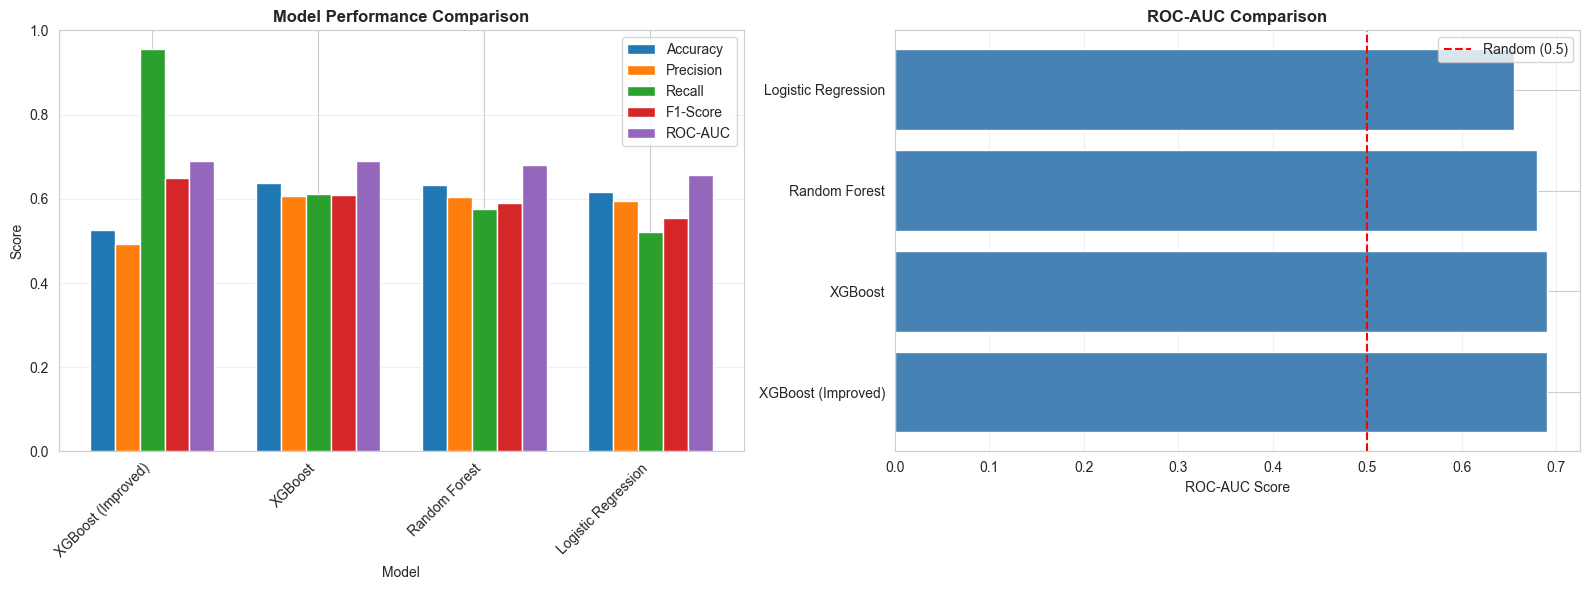

In [14]:
# Compare all models
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1-Score': [results[m]['f1'] for m in results.keys()],
    'ROC-AUC': [results[m]['roc_auc'] for m in results.keys()]
})

comparison_df = comparison_df.sort_values('ROC-AUC', ascending=False)
print("Model Comparison (sorted by ROC-AUC):")
print("="*70)
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot of metrics
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(comparison_df))
width = 0.15

for i, metric in enumerate(metrics_to_plot):
    axes[0].bar(x + i*width, comparison_df[metric], width, label=metric)

axes[0].set_xlabel('Model')
axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance Comparison', fontweight='bold')
axes[0].set_xticks(x + width * 2)
axes[0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])

# ROC-AUC comparison
axes[1].barh(comparison_df['Model'], comparison_df['ROC-AUC'], color='steelblue')
axes[1].set_xlabel('ROC-AUC Score')
axes[1].set_title('ROC-AUC Comparison', fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].axvline(x=0.5, color='r', linestyle='--', label='Random (0.5)')
axes[1].legend()

plt.tight_layout()
plt.show()


### ROC Curves and Precision-Recall Curves


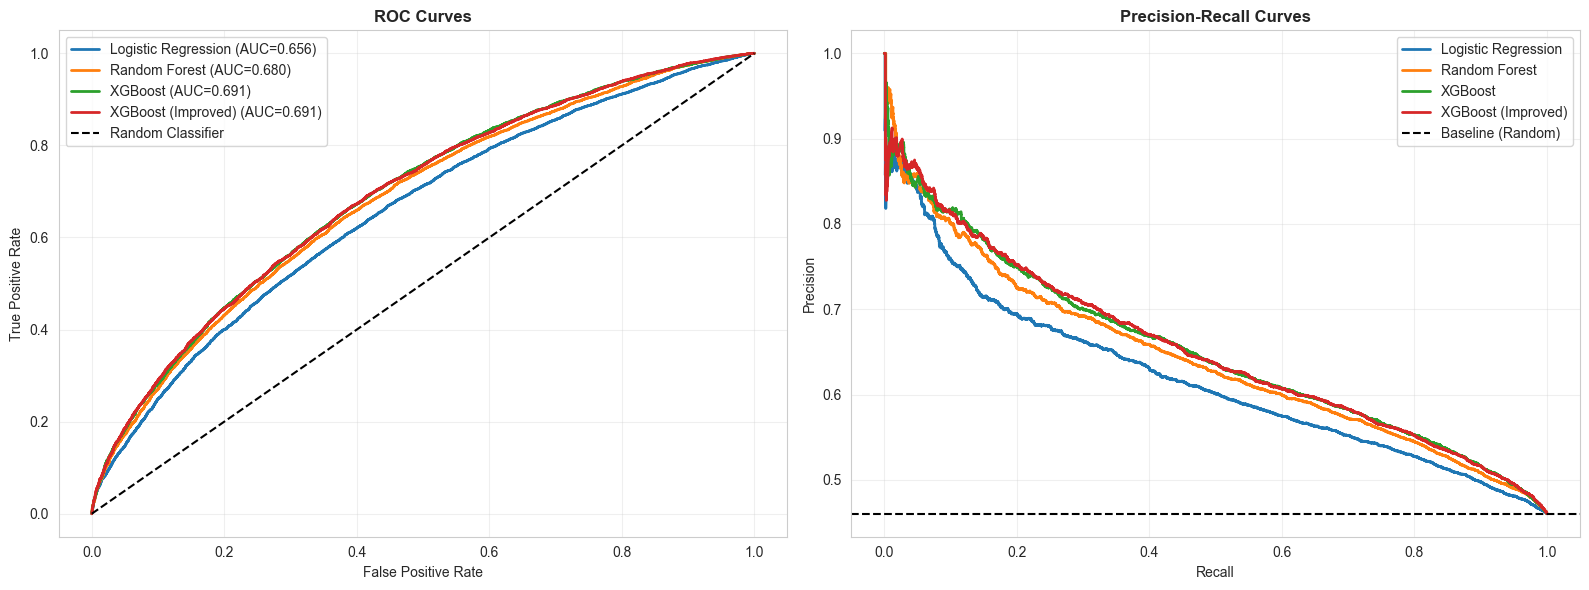

In [15]:
# Plot ROC curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
for model_name in results.keys():
    fpr, tpr, _ = roc_curve(y_test, results[model_name]['y_pred_proba'])
    axes[0].plot(fpr, tpr, label=f"{model_name} (AUC={results[model_name]['roc_auc']:.3f})", linewidth=2)

axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Precision-Recall Curve
for model_name in results.keys():
    precision, recall, _ = precision_recall_curve(y_test, results[model_name]['y_pred_proba'])
    axes[1].plot(recall, precision, label=f"{model_name}", linewidth=2)

axes[1].axhline(y=y_test.mean(), color='k', linestyle='--', label='Baseline (Random)')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curves', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


### Feature Importance Analysis


In [16]:
# Get feature importance from tree-based models
feature_names = X_encoded.columns.tolist()

def get_feature_importance(model, model_name, feature_names):
    """Extract feature importance from tree-based models"""
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        return importance_df
    elif hasattr(model, 'coef_'):
        # For logistic regression, use absolute coefficients
        importances = np.abs(model.coef_[0])
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        return importance_df
    else:
        return None

# Get feature importance for each model
feature_importance = {}

for model_name in results.keys():
    model = results[model_name]['model']
    importance_df = get_feature_importance(model, model_name, feature_names)
    if importance_df is not None:
        feature_importance[model_name] = importance_df
        print()
        print(f"{model_name} - Top 10 Most Important Features:")
        print("="*60)
        print(importance_df.head(10).to_string(index=False))



Logistic Regression - Top 10 Most Important Features:
                feature  importance
       number_inpatient    0.477095
       number_diagnoses    0.192321
       number_emergency    0.189021
      number_outpatient    0.111633
       anxiety_disorder    0.104550
         num_procedures    0.079109
             payer_code    0.053040
      medical_specialty    0.052152
medication_change_count    0.046062
             sertraline    0.045918

Random Forest - Top 10 Most Important Features:
           feature  importance
  number_inpatient    0.177337
            diag_1    0.071111
num_lab_procedures    0.065191
            diag_2    0.062880
   num_medications    0.061209
            diag_3    0.060309
  number_diagnoses    0.044855
               age    0.040954
  time_in_hospital    0.040028
 medical_specialty    0.038817

XGBoost - Top 10 Most Important Features:
                  feature  importance
         number_inpatient    0.282253
         number_emergency    0.051994
  

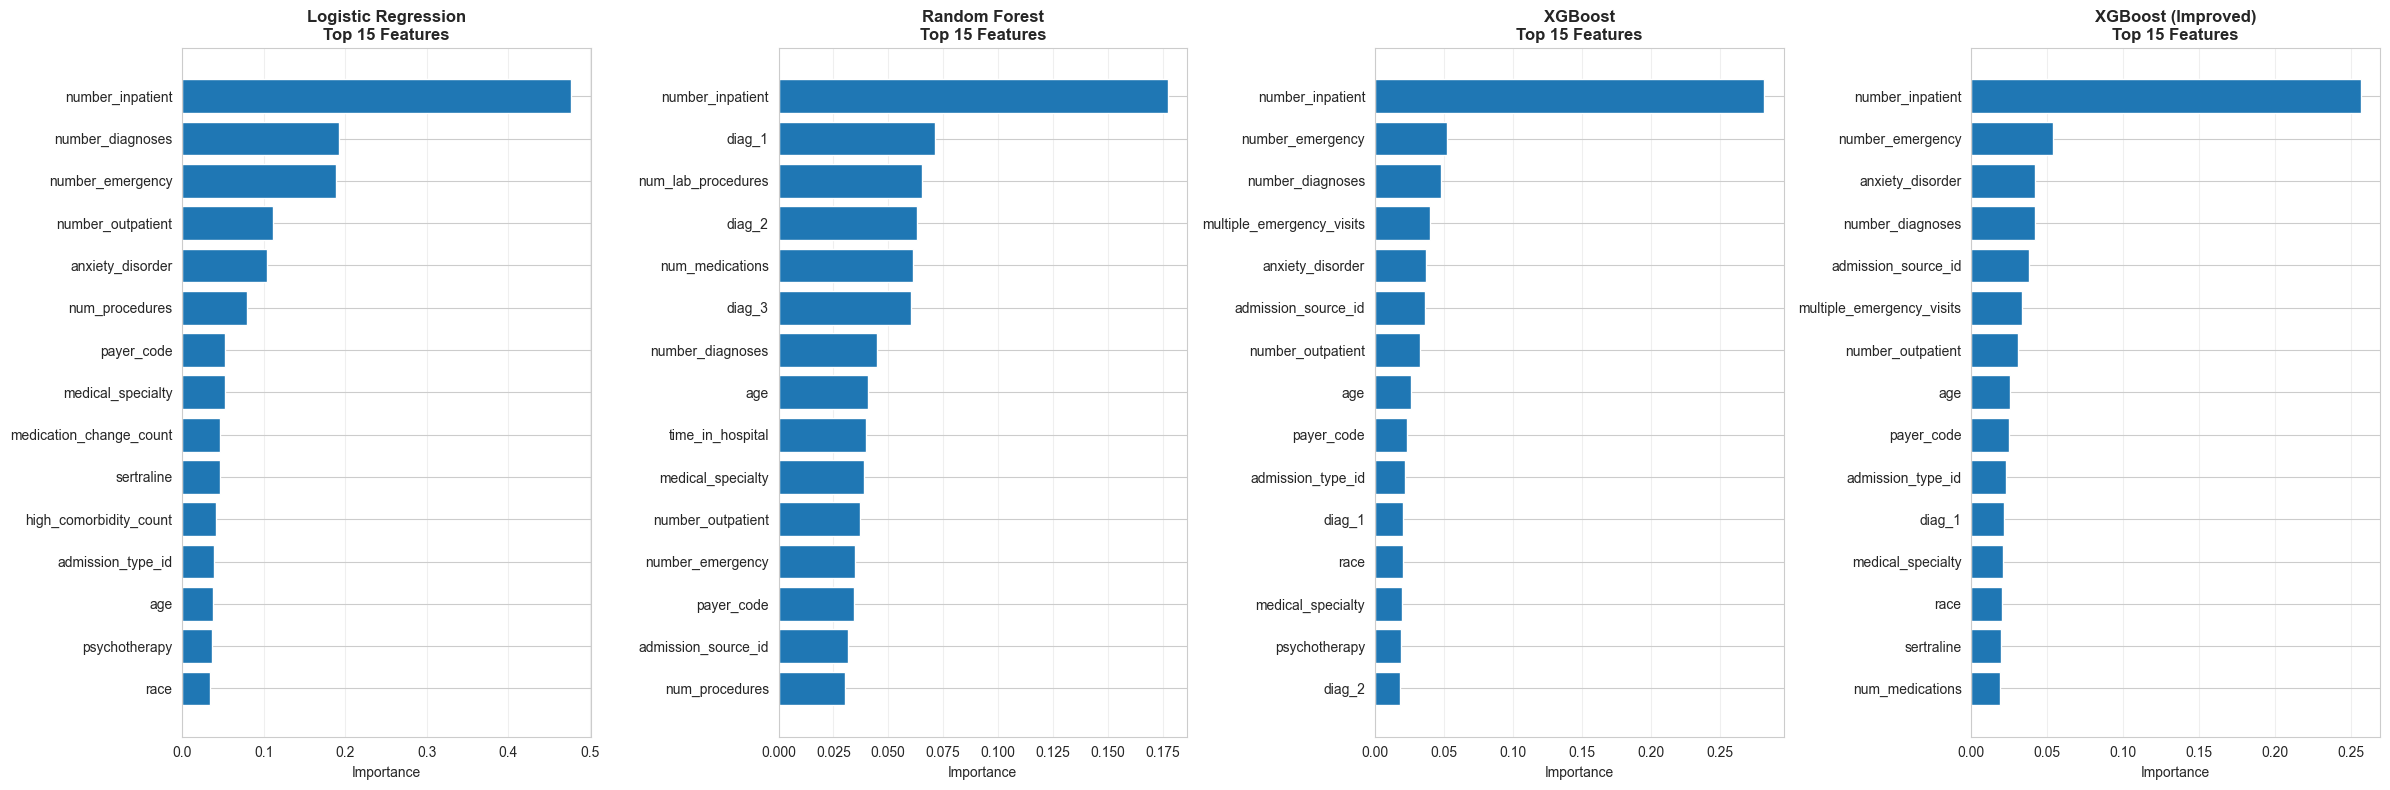

In [17]:
# Visualize top features for each model
n_models = len(feature_importance)
fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 8))

if n_models == 1:
    axes = [axes]

for idx, (model_name, importance_df) in enumerate(feature_importance.items()):
    top_n = 15
    top_features = importance_df.head(top_n)
    
    axes[idx].barh(range(len(top_features)), top_features['importance'].values[::-1])
    axes[idx].set_yticks(range(len(top_features)))
    axes[idx].set_yticklabels(top_features['feature'].values[::-1])
    axes[idx].set_xlabel('Importance')
    axes[idx].set_title(f'{model_name}\nTop {top_n} Features', fontweight='bold')
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


## Top 5 Factors for Readmission

Based on the best performing model, identify the top 5 factors.


Best Model: XGBoost (Improved)
ROC-AUC: 0.6908

TOP 5 FACTORS PREDICTING READMISSION

14. number_inpatient
   Importance: 0.2560

13. number_emergency
   Importance: 0.0539

43. anxiety_disorder
   Importance: 0.0422

18. number_diagnoses
   Importance: 0.0416

5. admission_source_id
   Importance: 0.0377



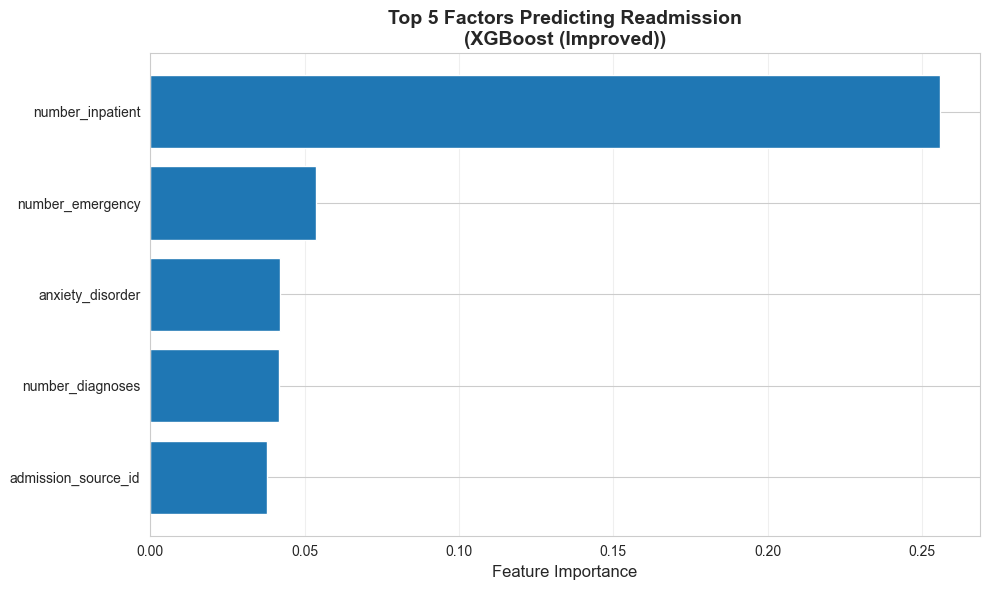

In [18]:
# Select the best model (highest ROC-AUC)
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
best_importance = feature_importance[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"ROC-AUC: {results[best_model_name]['roc_auc']:.4f}")
print()
print(f"{'='*70}")
print("TOP 5 FACTORS PREDICTING READMISSION")
print(f"{'='*70}")
print()

top_5 = best_importance.head(5)
for i, row in top_5.iterrows():
    print(f"{i+1}. {row['feature']}")
    print(f"   Importance: {row['importance']:.4f}")
    print()

# Visualize top 5
fig, ax = plt.subplots(figsize=(10, 6))
top_5_reversed = top_5.iloc[::-1]
ax.barh(range(len(top_5_reversed)), top_5_reversed['importance'].values)
ax.set_yticks(range(len(top_5_reversed)))
ax.set_yticklabels(top_5_reversed['feature'].values)
ax.set_xlabel('Feature Importance', fontsize=12)
ax.set_title(f'Top 5 Factors Predicting Readmission\n({best_model_name})', 
             fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


In [19]:
# Final summary
print("="*70)
print("MODELING SUMMARY")
print("="*70)
print()
print(f"Best Model: {best_model_name}")
print(f"  - ROC-AUC: {results[best_model_name]['roc_auc']:.4f}")
print(f"  - Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"  - Precision: {results[best_model_name]['precision']:.4f}")
print(f"  - Recall: {results[best_model_name]['recall']:.4f}")
print(f"  - F1-Score: {results[best_model_name]['f1']:.4f}")

print()
print(f"Top 5 Factors Predicting Readmission:")
for i, row in top_5.iterrows():
    print(f"  {i+1}. {row['feature']} (importance: {row['importance']:.4f})")

print()
print(f"{'='*70}")
print("Model training and evaluation complete!")
print(f"{'='*70}")


MODELING SUMMARY

Best Model: XGBoost (Improved)
  - ROC-AUC: 0.6908
  - Accuracy: 0.5268
  - Precision: 0.4928
  - Recall: 0.9556
  - F1-Score: 0.6503

Top 5 Factors Predicting Readmission:
  14. number_inpatient (importance: 0.2560)
  13. number_emergency (importance: 0.0539)
  43. anxiety_disorder (importance: 0.0422)
  18. number_diagnoses (importance: 0.0416)
  5. admission_source_id (importance: 0.0377)

Model training and evaluation complete!
